In [1]:
# Import required libraries and set plot style
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
# Load the original dataset
original_dataset = pd.read_csv('./Cu_alloys_database_2023_06_06.csv', encoding='utf-8', delimiter=';')

# Preprocessing

- Remove the DOI tag and alloy formula
- Convert alloy class to numerical format
- Convert Y/N questions into numerical format
- Drop duplicates

In [3]:
# Copy and preprocess the dataset
dataset = original_dataset.copy()
dataset.drop(columns=['DOI', 'Alloy formula'], inplace=True, errors='ignore')

alloy_classes = {
    'Cu low alloyed': 0,
    'Cu-Ni-Si alloys': 1,
    'Cu-Ti alloys': 2,
    'Cu-Be alloys': 3,
}

dataset['Alloy class'] = dataset['Alloy class'].apply(lambda x: alloy_classes[x] if x in alloy_classes else None)
dataset['Aging'] = dataset['Aging'].apply(lambda x: 1 if x == 'Y' else 0)
dataset['Secondary thermo-mechanical process'] = dataset['Secondary thermo-mechanical process'].apply(lambda x: 1 if x == 'Y' else 0)

# Drop columns not needed for this use case
dataset.drop(columns=['Ultimate tensile strength (MPa)', 'Yield strength (MPa)', 'Alloy class'], inplace=True, errors='ignore')
print("Before dropping rows with NaN values", dataset.shape)
dataset = dataset.dropna()
print("After dropping rows with NaN values", dataset.shape)

# Tss: temp of solid solutioning, tss: time of solid solutioning
# Tag: temp of ageing, tag: time of ageing

print(dataset.columns)

dataset.shape

Before dropping rows with NaN values (1831, 36)
After dropping rows with NaN values (1481, 36)
Index(['Cu', 'Al', 'Ag', 'B', 'Be', 'Ca', 'Co', 'Ce', 'Cr', 'Fe', 'Hf', 'La',
       'Mg', 'Mn', 'Mo', 'Nb', 'Nd', 'Ni', 'P', 'Pb', 'Pr', 'Si', 'Sn', 'Ti',
       'V', 'Zn', 'Zr', 'Tss (K)', 'tss (h)', 'CR reduction (%)', 'Aging',
       'Tag (K)', 'tag (h)', 'Secondary thermo-mechanical process',
       'Hardness (HV)', 'Electrical conductivity (%IACS)'],
      dtype='object')


(1481, 36)

# Problem Definition

Can we train a CVAE to perform the inverse design task of estimating the copper alloy composition and processing methods needed to achieve a certain electrical conductivity and hardness?

```
hardness, electrical conductivity --> CVAE Decoder --> process conditions, composition
```

In [4]:
# Split dataset into features (X) and targets (y)
X = dataset.drop(columns=['Hardness (HV)', 'Electrical conductivity (%IACS)', 'CR reduction (%)', 'Aging', 'Secondary thermo-mechanical process'])
y = dataset[['Hardness (HV)', 'Electrical conductivity (%IACS)']]


X

,Cu,Al,Ag,B,Be,Ca,Co,Ce,Cr,Fe,...,Si,Sn,Ti,V,Zn,Zr,Tss (K),tss (h),Tag (K),tag (h)
1,99.60,0.00,0.1,0.0,0.00,0,0.0,0.0,0.3,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,1223.0,1.00,673.0,0.25
2,99.60,0.00,0.1,0.0,0.00,0,0.0,0.0,0.3,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,1223.0,1.00,673.0,0.50
3,99.60,0.00,0.1,0.0,0.00,0,0.0,0.0,0.3,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,1223.0,1.00,673.0,1.00
4,99.60,0.00,0.1,0.0,0.00,0,0.0,0.0,0.3,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,1223.0,1.00,673.0,2.00
5,99.60,0.00,0.1,0.0,0.00,0,0.0,0.0,0.3,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,1223.0,1.00,673.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,92.57,0.13,0.0,0.0,1.66,0,0.0,0.0,0.0,0.0,...,0.31,0.0,3.0,0.0,0.0,0.0,1053.0,0.17,648.0,2.00
1821,92.57,0.13,0.0,0.0,1.66,0,0.0,0.0,0.0,0.0,...,0.31,0.0,3.0,0.0,0.0,0.0,1053.0,0.17,648.0,3.00
1822,92.57,0.13,0.0,0.0,1.66,0,0.0,0.0,0.0,0.0,...,0.31,0.0,3.0,0.0,0.0,0.0,1053.0,0.17,648.0,4.00
1823,92.57,0.13,0.0,0.0,1.66,0,0.0,0.0,0.0,0.0,...,0.31,0.0,3.0,0.0,0.0,0.0,1053.0,0.17,648.0,8.00


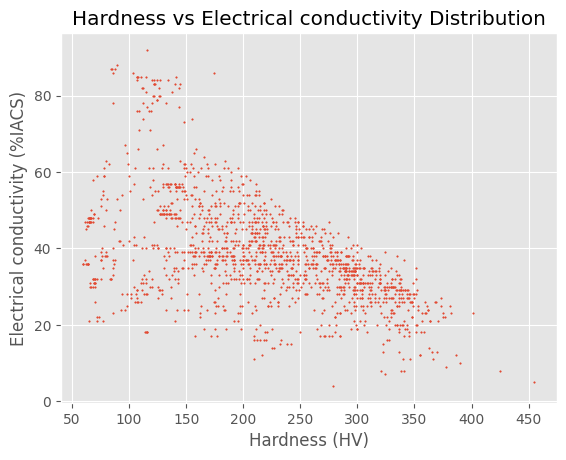

In [5]:
# Visualize the distribution of Hardness vs Electrical Conductivity
plt.scatter(dataset['Hardness (HV)'], dataset['Electrical conductivity (%IACS)'], s=1)
plt.xlabel('Hardness (HV)')
plt.ylabel('Electrical conductivity (%IACS)')
plt.title('Hardness vs Electrical conductivity Distribution')
plt.show()

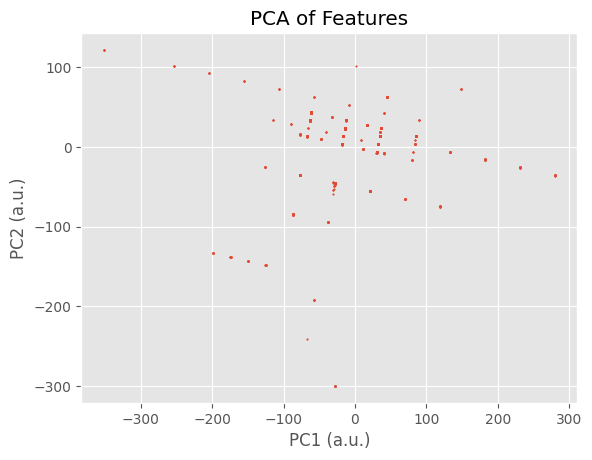

In [6]:
# PCA visualization of features
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(X)

plt.scatter(components[:, 0], components[:, 1], s=1)
plt.xlabel('PC1 (a.u.)')
plt.ylabel('PC2 (a.u.)')
plt.title('PCA of Features')
plt.show()

# Attempt 1: Traditional Neural Network

In [7]:
# Define and train a traditional neural network regressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RegressorNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 128], output_dim=2):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

model_reg = RegressorNet(input_dim=X.shape[1], hidden_dims=[128, 256, 256, 128, 128, 64, 64, 32, 32]).to(device)
optimizer_reg = optim.Adam(model_reg.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device)
train_ds = TensorDataset(X_tensor, y_tensor)
test_ds = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)    
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Training loop
epochs = 100
for epoch in range(epochs):
    model_reg.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer_reg.zero_grad()
        preds = model_reg(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer_reg.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(train_ds)
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluation on test set
model_reg.eval()
with torch.no_grad():
    mse_sum = 0.0
    total_samples = 0
    for xb, yb in test_loader:
        preds = model_reg(xb)
        mse_sum += ((preds - yb) ** 2).sum().item()
        total_samples += yb.numel()
    mse = mse_sum / total_samples
    rmse = mse ** 0.5
    print("Test RMSE:", rmse)

Epoch 10/100, Loss: 2927.3953
Epoch 20/100, Loss: 2232.6297
Epoch 20/100, Loss: 2232.6297
Epoch 30/100, Loss: 1948.4130
Epoch 30/100, Loss: 1948.4130
Epoch 40/100, Loss: 1829.4913
Epoch 40/100, Loss: 1829.4913
Epoch 50/100, Loss: 1831.9301
Epoch 50/100, Loss: 1831.9301
Epoch 60/100, Loss: 1618.3415
Epoch 60/100, Loss: 1618.3415
Epoch 70/100, Loss: 1584.0484
Epoch 70/100, Loss: 1584.0484
Epoch 80/100, Loss: 1707.1317
Epoch 80/100, Loss: 1707.1317
Epoch 90/100, Loss: 1412.0171
Epoch 90/100, Loss: 1412.0171
Epoch 100/100, Loss: 1400.5921
Test RMSE: 35.29434630889746
Epoch 100/100, Loss: 1400.5921
Test RMSE: 35.29434630889746


# Attempt 2: CVAE + VampPrior

In [8]:
# Define CVAE and VampPrior models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X.shape[1]
cond_dim = y.shape[1]
latent_dim = 8  # Increased latent dimension

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim + cond_dim, 256)
        self.norm1 = nn.LayerNorm(256)
        self.fc2 = nn.Linear(256, 128)
        self.norm2 = nn.LayerNorm(128)
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

    def forward(self, x, c):
        h = torch.nn.LeakyReLU()(self.norm1(self.fc1(torch.cat([x, c], dim=1))))
        h = torch.nn.LeakyReLU()(self.norm2(self.fc2(h)))
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z, mean, logvar

class FiLM(nn.Module):
    def __init__(self, cond_dim, feature_dim):
        super().__init__()
        self.gamma = nn.Linear(cond_dim, feature_dim)
        self.beta = nn.Linear(cond_dim, feature_dim)

    def forward(self, features, cond):
        gamma = self.gamma(cond)
        beta = self.beta(cond)
        return features * gamma + beta

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim + cond_dim, 128)
        self.norm1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 256)
        self.norm2 = nn.LayerNorm(256)
        self.fc_out = nn.Linear(256, input_dim)

    def forward(self, z, c):
        h = torch.nn.LeakyReLU()(self.norm1(self.fc1(torch.cat([z, c], dim=1))))
        h = torch.nn.LeakyReLU()(self.norm2(self.fc2(h)))
        return self.fc_out(h)

class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder()
        self.dec = Decoder()
    def forward(self, x, c):
        z, mean, logvar = self.enc(x, c)
        x_recon         = self.dec(z, c)
        return x_recon, mean, logvar

In [9]:
# Train/test/val split and data augmentation for CVAE
from sklearn.model_selection import train_test_split
import numpy as np

# Split into train / val / test
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42
)
X_train_np, X_val_np,  y_train_np, y_val_np  = train_test_split(
    X_train_np, y_train_np, test_size=0.2, random_state=42
)

# Data augmentation: add small Gaussian noise to features in the training set
noise_level = 0.005
X_std = X_train_np.std(axis=0, keepdims=True)
noise = noise_level * X_std * np.random.randn(*X_train_np.shape)
X_aug = X_train_np + noise
X_train_np = np.vstack([X_train_np, X_aug])
y_train_np = np.vstack([y_train_np, y_train_np])

def make_loader(X_np, y_np, batch_size=64, shuffle=True):
    Xt = torch.from_numpy(X_np).float().to(device)
    yt = torch.from_numpy(y_np).float().to(device)
    ds = TensorDataset(Xt, yt)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

train_loader = make_loader(X_train_np, y_train_np)
val_loader   = make_loader(X_val_np,   y_val_np,   shuffle=False)
test_loader  = make_loader(X_test_np,  y_test_np,  shuffle=False)

# Model, optimizer, and training loop with early stopping
model   = CVAE().to(device)
opt     = optim.Adam(model.parameters())
epochs  = 300
patience = 20

best_val = float('inf')
wait = 0

beta = 0.1  # Adjust this value to balance reconstruction and regularization

from torch.optim.lr_scheduler import CyclicLR
scheduler = CyclicLR(opt, base_lr=1e-4, max_lr=1e-3, step_size_up=200, mode='triangular')

for epoch in range(1, epochs + 1):
    model.train()
    for xb, yb in train_loader:
        opt.zero_grad()
        xr, mu, logvar = model(xb, yb)
        recon = nn.functional.mse_loss(xr, xb, reduction='sum')
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon + beta * kl
        loss.backward()
        opt.step()
        scheduler.step()

    # Compute train+val loss & RRMSE
    def eval_loader(loader):
        model.eval()
        mse_sum = 0.0
        true_sum = 0.0
        cnt = 0
        with torch.no_grad():
            for xb, yb in loader:
                xr, _, _ = model(xb, yb)
                diff = xr - xb
                mse_sum += float((diff**2).sum())
                true_sum += float(xb.sum())
                cnt += xb.numel()
        rmse  = np.sqrt(mse_sum / cnt)
        mean_true = true_sum / cnt
        return rmse / mean_true, mse_sum / cnt

    rrmse_tr, mse_tr = eval_loader(train_loader)
    rrmse_val, mse_val = eval_loader(val_loader)
    print(f"Epoch {epoch:03d}  train RRMSE={rrmse_tr:.4f}  val RRMSE={rrmse_val:.4f}")

    # Early stopping
    if mse_val < best_val:
        best_val = mse_val
        torch.save(model.state_dict(), 'best.pt')
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping.")
            break

# Load best model & final test evaluation
model.load_state_dict(torch.load('best.pt'))
rrmse_test, _ = eval_loader(test_loader)
print(f"Test RRMSE = {rrmse_test:.4f}")

Epoch 001  train RRMSE=3.8472  val RRMSE=3.8479
Epoch 002  train RRMSE=3.8382  val RRMSE=3.8389
Epoch 002  train RRMSE=3.8382  val RRMSE=3.8389
Epoch 003  train RRMSE=3.8302  val RRMSE=3.8309
Epoch 003  train RRMSE=3.8302  val RRMSE=3.8309
Epoch 004  train RRMSE=3.8197  val RRMSE=3.8205
Epoch 004  train RRMSE=3.8197  val RRMSE=3.8205
Epoch 005  train RRMSE=3.8056  val RRMSE=3.8064
Epoch 005  train RRMSE=3.8056  val RRMSE=3.8064
Epoch 006  train RRMSE=3.7867  val RRMSE=3.7875
Epoch 006  train RRMSE=3.7867  val RRMSE=3.7875
Epoch 007  train RRMSE=3.7621  val RRMSE=3.7628
Epoch 007  train RRMSE=3.7621  val RRMSE=3.7628
Epoch 008  train RRMSE=3.7367  val RRMSE=3.7374
Epoch 008  train RRMSE=3.7367  val RRMSE=3.7374
Epoch 009  train RRMSE=3.7137  val RRMSE=3.7143
Epoch 009  train RRMSE=3.7137  val RRMSE=3.7143
Epoch 010  train RRMSE=3.6940  val RRMSE=3.6946
Epoch 010  train RRMSE=3.6940  val RRMSE=3.6946
Epoch 011  train RRMSE=3.6783  val RRMSE=3.6789
Epoch 011  train RRMSE=3.6783  val RRMSE

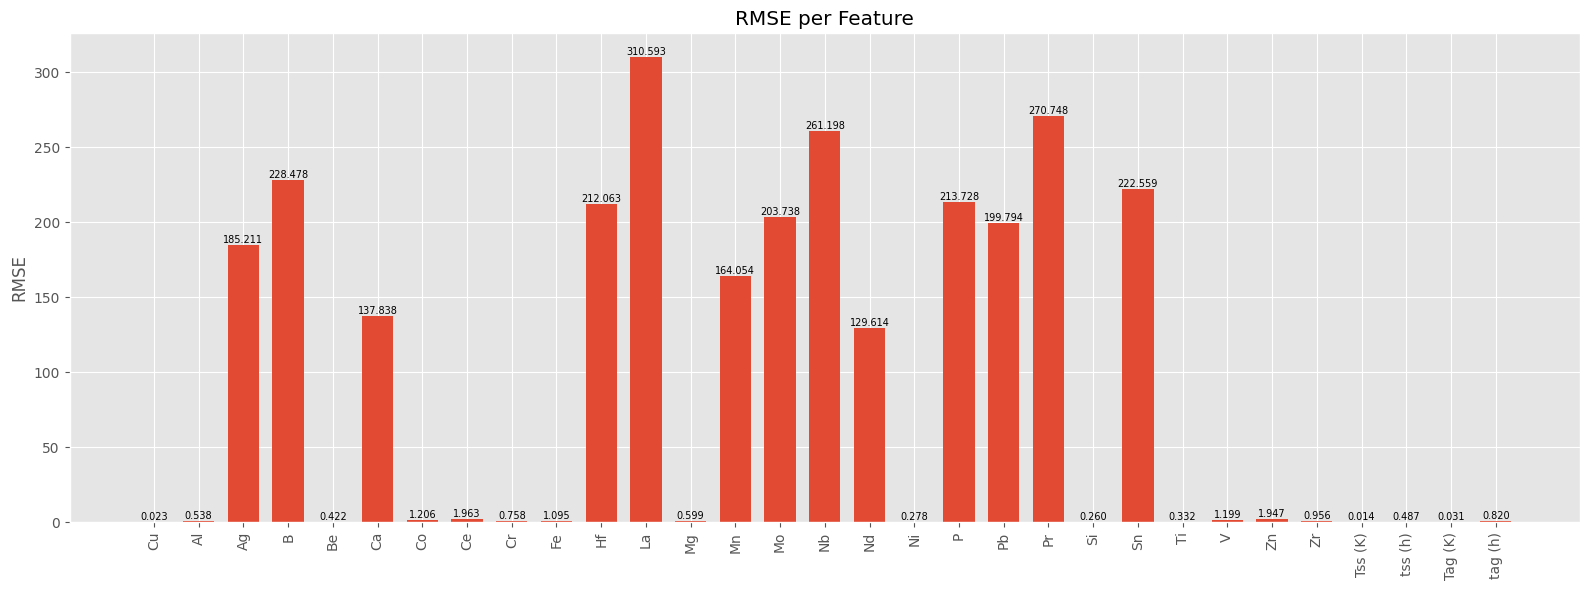

c:\Users\aniru\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
c:\Users\aniru\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


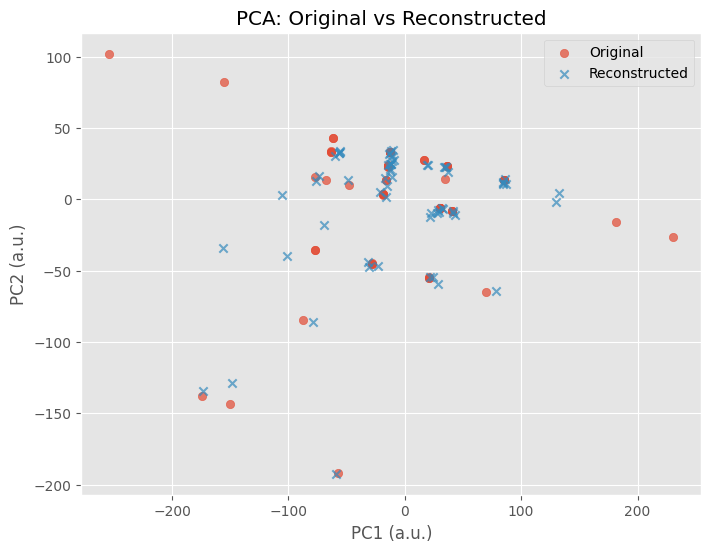

In [10]:
# Evaluate per-feature RMSE and visualize PCA of original vs reconstructed
# get one batch
xb_batch, yb_batch = next(iter(test_loader))
with torch.no_grad():
    xr_batch, _, _ = model(xb_batch, yb_batch)

xb_np = xb_batch.cpu().numpy()
xr_np = xr_batch.cpu().numpy()

# compute per‐feature relative RMSE
#    sqrt(mean((xr-xb)^2) / mean(xb^2))
# compute per‐feature relative RMSE with eps to avoid division by zero
den = np.mean(xb_np**2, axis=0)
den = np.where(den == 0, 1e-8, den)
rmse_feat = np.sqrt(np.mean((xr_np - xb_np)**2, axis=0) / den)

plt.figure(figsize=(16,6))
bars = plt.bar(X.columns, rmse_feat, width=0.7)
plt.xticks(rotation=90)
plt.ylabel('RMSE')
plt.title('RMSE per Feature')

# annotate each bar
for bar, val in zip(bars, rmse_feat):
    plt.text(bar.get_x() + bar.get_width()/2, val,
             f"{val:.3f}", ha='center', va='bottom', fontsize=7)

plt.tight_layout()
plt.show()

# PCA scatter of original vs reconstructed
# Fit PCA on the original data
pca = PCA(n_components=2)
pca.fit(X)

# Transform the original and reconstructed data
orig_proj = pca.transform(xb_np)
rec_proj = pca.transform(xr_np)

# Plot PCA scatter of original vs reconstructed
plt.figure(figsize=(8, 6))
plt.scatter(orig_proj[:, 0], orig_proj[:, 1], label='Original', alpha=0.7)
plt.scatter(rec_proj[:, 0], rec_proj[:, 1], label='Reconstructed', alpha=0.7, marker='x')
plt.xlabel('PC1 (a.u.)')
plt.ylabel('PC2 (a.u.)')
plt.title('PCA: Original vs Reconstructed')
plt.legend()
plt.show()

Epoch 1/150, Train Loss: 2.5617, Val Loss: 2.5861
Epoch 2/150, Train Loss: 2.4625, Val Loss: 2.6389
Epoch 2/150, Train Loss: 2.4625, Val Loss: 2.6389
Epoch 3/150, Train Loss: 2.3533, Val Loss: 2.5174
Epoch 3/150, Train Loss: 2.3533, Val Loss: 2.5174
Epoch 4/150, Train Loss: 2.1180, Val Loss: 2.1885
Epoch 4/150, Train Loss: 2.1180, Val Loss: 2.1885
Epoch 5/150, Train Loss: 1.9841, Val Loss: 2.0369
Epoch 5/150, Train Loss: 1.9841, Val Loss: 2.0369
Epoch 6/150, Train Loss: 1.8811, Val Loss: 2.0219
Epoch 6/150, Train Loss: 1.8811, Val Loss: 2.0219
Epoch 7/150, Train Loss: 1.8161, Val Loss: 1.8238
Epoch 7/150, Train Loss: 1.8161, Val Loss: 1.8238
Epoch 8/150, Train Loss: 1.7423, Val Loss: 1.5297
Epoch 8/150, Train Loss: 1.7423, Val Loss: 1.5297
Epoch 9/150, Train Loss: 1.5421, Val Loss: 1.6171
Epoch 9/150, Train Loss: 1.5421, Val Loss: 1.6171
Epoch 10/150, Train Loss: 1.5045, Val Loss: 1.4322
Epoch 10/150, Train Loss: 1.5045, Val Loss: 1.4322
Epoch 11/150, Train Loss: 1.4172, Val Loss: 1.55

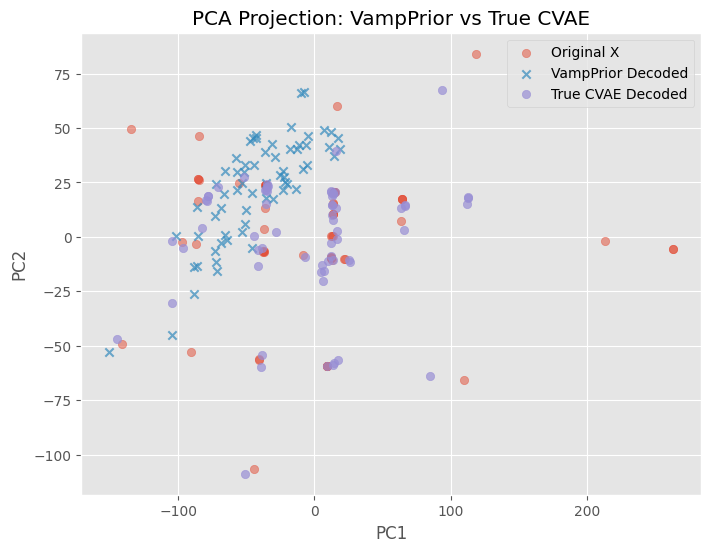

In [11]:
# Define and train VampPrior, evaluate and visualize
# ---- Implements a VampPrior: a mixture of variational posteriors on learned pseudo-inputs ----
class VampPrior(nn.Module):
    def __init__(self, num_pseudos=5):
        super().__init__()
        self.num_pseudos = num_pseudos
        # Pseudo-inputs split into x and c parts
        self.pseudos_x = nn.Parameter(torch.randn(num_pseudos, input_dim))
        self.pseudos_c = nn.Parameter(torch.randn(num_pseudos, cond_dim))

    def forward(self, batch_size):
        # Expand pseudos to batch
        # shapes: [B, K, input_dim], [B, K, cond_dim]
        px = self.pseudos_x.unsqueeze(0).expand(batch_size, -1, -1)
        pc = self.pseudos_c.unsqueeze(0).expand(batch_size, -1, -1)
        # Flatten to (B*K, dims)
        flat_x = px.reshape(batch_size * self.num_pseudos, input_dim)
        flat_c = pc.reshape(batch_size * self.num_pseudos, cond_dim)
        # Encode to get mixture component params
        _, mu, logvar = model.enc(flat_x, flat_c)
        # Reshape to [B, K, latent_dim]
        mu = mu.view(batch_size, self.num_pseudos, latent_dim)
        logvar = logvar.view(batch_size, self.num_pseudos, latent_dim)
        # Randomly select component per sample
        idx = torch.randint(0, self.num_pseudos, (batch_size,), device=mu.device)
        mu_sel = mu[torch.arange(batch_size), idx]
        lv_sel = logvar[torch.arange(batch_size), idx]
        eps = torch.randn_like(mu_sel)
        return mu_sel + eps * torch.exp(0.5 * lv_sel)

# Instantiate VampPrior
vamp_prior = VampPrior(num_pseudos=50).to(device)

# Train the VampPrior by aligning its output with the encoder’s posterior means
optimizer_vamp = optim.Adam(vamp_prior.parameters(), lr=1e-3)

epochs_vamp = 150

best_val_loss = float('inf')
patience = 10
trigger_count = 0

def eval_vamp_prior(loader):
    vamp_prior.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            batch_size = xb.size(0)
            _, mu_true, _ = model.enc(xb, yb)
            pred_z = vamp_prior(batch_size)
            total_loss += criterion(pred_z, mu_true).item()
            total_count += batch_size
    return total_loss / total_count



for epoch in range(epochs_vamp):
    vamp_prior.train()
    total_loss = 0.0
    count = 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_vamp.zero_grad()
        with torch.no_grad():
            _, mu_true, _ = model.enc(xb, yb)
        batch_size = xb.size(0)
        z_sample = vamp_prior(batch_size)
        loss = criterion(z_sample, mu_true)
        loss.backward()
        optimizer_vamp.step()
        total_loss += loss.item()
        count += batch_size
    
    train_loss = total_loss / count
    
    # Evaluate on test set (could also use a validation set if available)
    val_loss = eval_vamp_prior(test_loader)
    
    print(f"Epoch {epoch+1}/{epochs_vamp}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_count = 0
    else:
        trigger_count += 1
        if trigger_count >= patience:
            print("Early stopping triggered.")
            break

# ---- Evaluation and Visualization ----
criterion = nn.MSELoss(reduction='sum')

# Evaluate latent-space MSE between VampPrior samples and encoder means
def eval_vamp_prior(loader):
    vamp_prior.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            batch_size = xb.size(0)
            # True posterior means
            _, mu_true, _ = model.enc(xb, yb)
            # VampPrior samples
            pred_z = vamp_prior(batch_size)
            total_loss += criterion(pred_z, mu_true).item()
            total_count += batch_size
    return total_loss / total_count

print("Test Loss (VampPrior):", eval_vamp_prior(test_loader))

# Visual comparison via PCA
# Grab one batch
xb_b, yb_b = next(iter(train_loader))
xb_b, yb_b = xb_b.to(device), yb_b.to(device)
with torch.no_grad():
    # Samples
    z_vamp = vamp_prior(xb_b.size(0))
    x_dec_vamp = model.dec(z_vamp, yb_b)
    # True encoder means
    _, mu_true, _ = model.enc(xb_b, yb_b)
    x_dec_true = model.dec(mu_true, yb_b)

# Convert to numpy
orig_np = xb_b.cpu().numpy()
vamp_np = x_dec_vamp.cpu().numpy()
true_np = x_dec_true.cpu().numpy()

# PCA
pca = PCA(n_components=2)
pca.fit(orig_np)
proj_orig = pca.transform(orig_np)
proj_vamp = pca.transform(vamp_np)
proj_true = pca.transform(true_np)

plt.figure(figsize=(8, 6))
plt.scatter(proj_orig[:, 0], proj_orig[:, 1], label='Original X', alpha=0.5)
plt.scatter(proj_vamp[:, 0], proj_vamp[:, 1], label='VampPrior Decoded', alpha=0.7, marker='x')
plt.scatter(proj_true[:, 0], proj_true[:, 1], label='True CVAE Decoded', alpha=0.7, marker='o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection: VampPrior vs True CVAE')
plt.legend()
plt.show()

# Attempt 3: Adversarial Latent Autoencoder

In [22]:
# Define ALAE (Adversarial Latent Autoencoder) and its training setup
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Encoder: encodes [X, y] to latent z.
class EncoderALAE(nn.Module):
    def __init__(self, input_dim, cond_dim, latent_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
    def forward(self, x, c):
        x_cat = torch.cat([x, c], dim=1)
        z = self.fc(x_cat)
        return z

# Decoder: reconstructs X from [z, y].
class DecoderALAE(nn.Module):
    def __init__(self, latent_dim, cond_dim, output_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
    def forward(self, z, c):
        z_cat = torch.cat([z, c], dim=1)
        x_recon = self.fc(z_cat)
        return x_recon

# Discriminator: distinguishes between samples from the prior and those from the encoder.
class Discriminator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.net(z)

# Hyperparameters
input_dim = X.shape[1]
cond_dim = y.shape[1]
latent_dim = 8
adv_weight = 1000 # weight for the adversarial loss in the autoencoder objective
lr = 1e-3
epochs_aae = 200
batch_size = 64

# Create a dataset and loader (using values from X and y)
dataset_aae = TensorDataset(
    torch.tensor(X.values, dtype=torch.float32).to(device),
    torch.tensor(y.values, dtype=torch.float32).to(device)
)
train_loader_aae = DataLoader(dataset_aae, batch_size=batch_size, shuffle=True)

# Instantiate networks
encoder_aae = EncoderALAE(input_dim, cond_dim, latent_dim).to(device)
decoder_aae = DecoderALAE(latent_dim, cond_dim, input_dim).to(device)
discriminator = Discriminator(latent_dim).to(device)

# Optimizers for autoencoder and discriminator
optimizer_ae = optim.Adam(list(encoder_aae.parameters()) + list(decoder_aae.parameters()), lr=lr)
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr)

mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

In [23]:
# Train ALAE with early stopping and validation
from torch.utils.data import random_split

# Increase epochs and set early stopping parameters.
epochs_aae = 500
patience = 25
best_val_loss = float('inf')
patience_counter = 0

# Split dataset into training and validation (80/20 split).
train_size = int(0.8 * len(dataset_aae))
val_size = len(dataset_aae) - train_size
train_dataset, val_dataset = random_split(dataset_aae, [train_size, val_size])
train_loader_aae = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_aae = DataLoader(val_dataset, batch_size=batch_size)

for epoch in range(epochs_aae):
    encoder_aae.train()
    decoder_aae.train()
    discriminator.train()
    
    total_recon_loss = 0.0
    total_adv_loss = 0.0
    total_disc_loss = 0.0
    
    for xb, yb in train_loader_aae:
        cur_bs = xb.size(0)
        
        # --- Train Discriminator ---
        optimizer_disc.zero_grad()
        z_prior = torch.randn(cur_bs, latent_dim, device=device)
        z_enc = encoder_aae(xb, yb).detach()
        d_real = discriminator(z_prior)
        d_fake = discriminator(z_enc)
        
        real_labels = torch.ones(cur_bs, 1, device=device)
        fake_labels = torch.zeros(cur_bs, 1, device=device)
        
        loss_d_real = bce_loss(d_real, real_labels)
        loss_d_fake = bce_loss(d_fake, fake_labels)
        loss_disc = (loss_d_real + loss_d_fake) / 2
        
        loss_disc.backward()
        optimizer_disc.step()
        
        # --- Train Autoencoder (Encoder + Decoder) ---
        optimizer_ae.zero_grad()
        z_enc = encoder_aae(xb, yb)
        x_recon = decoder_aae(z_enc, yb)
        recon_loss = mse_loss(x_recon, xb)
        
        d_fake_for_adv = discriminator(z_enc)
        adv_loss = bce_loss(d_fake_for_adv, real_labels)
        
        loss_ae = recon_loss + adv_weight * adv_loss
        loss_ae.backward()
        optimizer_ae.step()
        
        total_recon_loss += recon_loss.item() * cur_bs
        total_adv_loss += adv_loss.item() * cur_bs
        total_disc_loss += loss_disc.item() * cur_bs

    total_samples = len(train_dataset)
    train_recon = total_recon_loss / total_samples
    train_adv = total_adv_loss / total_samples
    train_disc = total_disc_loss / total_samples
    
    # --- Evaluate on validation set ---
    encoder_aae.eval()
    decoder_aae.eval()
    
    val_loss = 0.0
    with torch.no_grad():
        for xb_val, yb_val in val_loader_aae:
            cur_bs_val = xb_val.size(0)
            z_enc_val = encoder_aae(xb_val, yb_val)
            x_recon_val = decoder_aae(z_enc_val, yb_val)
            loss_val = mse_loss(x_recon_val, xb_val)
            val_loss += loss_val.item() * cur_bs_val
    val_loss = val_loss / len(val_dataset)
    
    print(f"Epoch [{epoch+1}/{epochs_aae}], Train Recon: {train_recon:.4f}, "
          f"Train Adv: {train_adv:.4f}, Train Disc: {train_disc:.4f}, Val Recon: {val_loss:.4f}")
    
    # Early stopping check (using validation reconstruction loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(encoder_aae.state_dict(), 'best_encoder.pt')
        torch.save(decoder_aae.state_dict(), 'best_decoder.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/500], Train Recon: 52605.6825, Train Adv: 4.6486, Train Disc: 0.7281, Val Recon: 28256.2617
Epoch [2/500], Train Recon: 7380.1342, Train Adv: 14.7683, Train Disc: 0.3875, Val Recon: 981.2848
Epoch [3/500], Train Recon: 1431.1054, Train Adv: 17.8968, Train Disc: 0.3877, Val Recon: 533.9013
Epoch [4/500], Train Recon: 346.0273, Train Adv: 17.1381, Train Disc: 0.3800, Val Recon: 300.8381
Epoch [5/500], Train Recon: 289.1127, Train Adv: 15.0232, Train Disc: 0.3700, Val Recon: 358.6141
Epoch [6/500], Train Recon: 310.2600, Train Adv: 12.1768, Train Disc: 0.3155, Val Recon: 403.2896
Epoch [7/500], Train Recon: 275.3518, Train Adv: 11.6819, Train Disc: 0.2519, Val Recon: 202.6251
Epoch [8/500], Train Recon: 188.2303, Train Adv: 12.9409, Train Disc: 0.1994, Val Recon: 319.7481
Epoch [9/500], Train Recon: 295.4079, Train Adv: 15.5922, Train Disc: 0.1964, Val Recon: 186.1915
Epoch [10/500], Train Recon: 167.8308, Train Adv: 14.3838, Train Disc: 0.1834, Val Recon: 221.0254
Epoch [11/500]

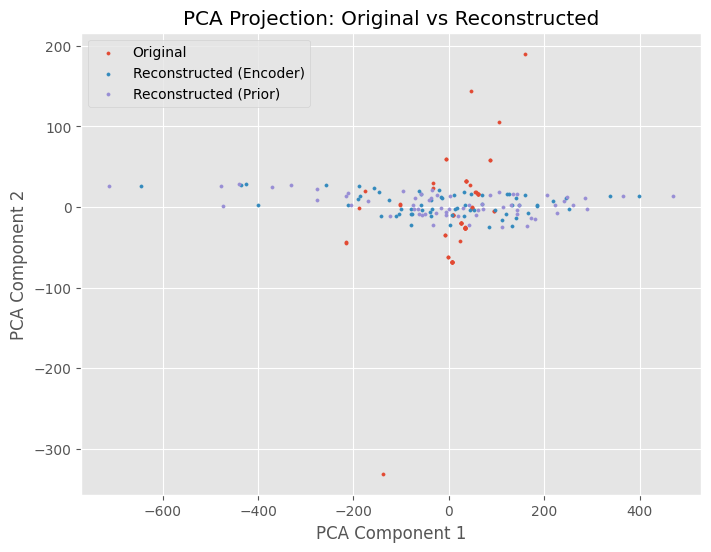

In [24]:
# Evaluate ALAE reconstruction and visualize with PCA
# Evaluate reconstruction on one batch (for example purposes)
encoder_aae.eval()
decoder_aae.eval()
with torch.no_grad():
    xb_test, yb_test = next(iter(train_loader_aae))
    
    # Reconstruction from encoded samples
    x_recon_test = decoder_aae(encoder_aae(xb_test, yb_test), yb_test)
    
    # Reconstruction from a predetermined prior (sample z from N(0,1))
    z_prior_sample = torch.randn(xb_test.size(0), latent_dim, device=device)
    x_recon_from_prior = decoder_aae(z_prior_sample, yb_test)

    # Combine original, encoder-based and prior-based reconstructions for PCA visualization
    combined = torch.cat([xb_test, x_recon_test, x_recon_from_prior], dim=0).cpu().numpy()
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(combined)

    n = xb_test.shape[0]
    orig_transformed = pca_result[:n, :]
    enc_transformed = pca_result[n:2*n, :]
    prior_transformed = pca_result[2*n:3*n, :]

    plt.figure(figsize=(8,6))
    plt.scatter(orig_transformed[:, 0], orig_transformed[:, 1], s=5, label="Original")
    plt.scatter(enc_transformed[:, 0], enc_transformed[:, 1], s=5, label="Reconstructed (Encoder)")
    plt.scatter(prior_transformed[:, 0], prior_transformed[:, 1], s=5, label="Reconstructed (Prior)")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("PCA Projection: Original vs Reconstructed")
    plt.legend()
    plt.show()

# Attempt 3.1: Hyperparameter Optimization for Adversarial Loss Weighting

In [15]:
# Hyperparameter optimization for adversarial loss weight (alpha tuning)
# Attempt 3.1: Hyperparameter Optimization for Adv. Loss Weight (alpha tuning)
alpha_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]
results = []

for alpha in alpha_list:
    # reinitialize weights
    for net in (encoder_aae, decoder_aae, discriminator):
        net.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)
    adv_weight = alpha
    opt_ae = optim.Adam(list(encoder_aae.parameters()) + list(decoder_aae.parameters()), lr=lr)
    opt_disc = optim.Adam(discriminator.parameters(), lr=lr)
    # short training loop
    for _ in range(50):
        for xb, yb in train_loader_aae:
            # train discriminator
            opt_disc.zero_grad()
            z_p = torch.randn(xb.size(0), latent_dim, device=device)
            z_e = encoder_aae(xb, yb).detach()
            d_loss = 0.5*(bce_loss(discriminator(z_p), torch.ones(xb.size(0),1,device=device))
                          + bce_loss(discriminator(z_e), torch.zeros(xb.size(0),1,device=device)))
            d_loss.backward(); opt_disc.step()
            # train autoencoder
            opt_ae.zero_grad()
            z_e2 = encoder_aae(xb, yb)
            recon = mse_loss(decoder_aae(z_e2, yb), xb)
            adv  = bce_loss(discriminator(z_e2), torch.ones(xb.size(0),1,device=device))
            (recon + adv_weight*adv).backward(); opt_ae.step()
    # evaluate prior‐reconstruction error on validation set
    encoder_aae.eval(); decoder_aae.eval()
    errs = []
    with torch.no_grad():
        for xb_val, yb_val in val_loader_aae:
            zp = torch.randn(xb_val.size(0), latent_dim, device=device)
            rec_p = decoder_aae(zp, yb_val)
            errs.append(mse_loss(rec_p, xb_val).item())
    results.append((alpha, sum(errs)/len(errs)))

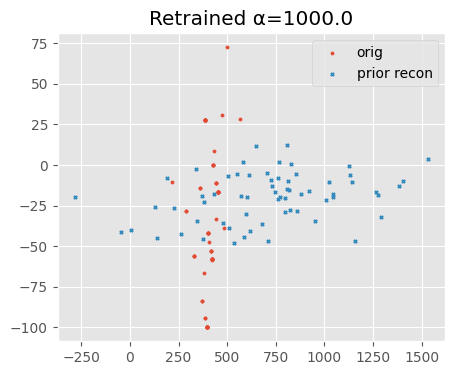

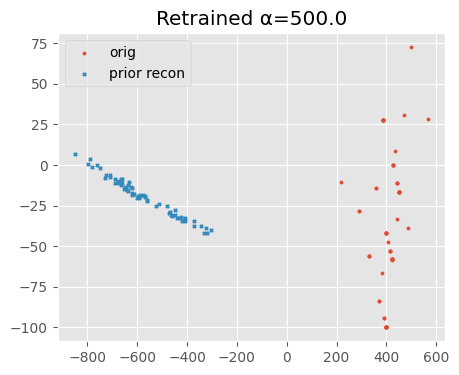

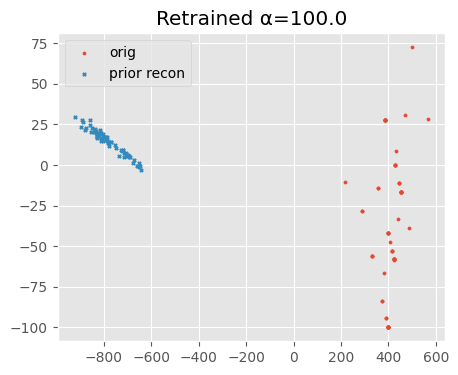

In [16]:
# Retrain ALAE with best alphas and visualize
# select top‐3 alphas
best = sorted(results, key=lambda x: x[1])[:3]
best_alphas = [a for a,_ in best]

# retrain with a full loop for each of the best alphas, then visualize
for a in best_alphas:
    # re-init
    for net in (encoder_aae, decoder_aae, discriminator):
        net.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)

    adv_weight = a
    opt_ae = optim.Adam(list(encoder_aae.parameters()) + list(decoder_aae.parameters()), lr=lr)
    opt_disc = optim.Adam(discriminator.parameters(), lr=lr)

    # full training loop (example: 100 epochs)
    for epoch in range(200):
        encoder_aae.train()
        decoder_aae.train()
        discriminator.train()
        for xb, yb in train_loader_aae:            # train discriminator
            opt_disc.zero_grad()
            z_p = torch.randn(xb.size(0), latent_dim, device=device)
            z_e = encoder_aae(xb, yb).detach()
            loss_d = 0.5 * (
                bce_loss(discriminator(z_p), torch.ones(xb.size(0),1,device=device))
                + bce_loss(discriminator(z_e), torch.zeros(xb.size(0),1,device=device))
            )
            loss_d.backward()
            opt_disc.step()

            # train autoencoder
            opt_ae.zero_grad()
            z_e2 = encoder_aae(xb, yb)
            loss_recon = mse_loss(decoder_aae(z_e2, yb), xb)
            loss_adv = bce_loss(discriminator(z_e2), torch.ones(xb.size(0),1,device=device))
            (loss_recon + adv_weight * loss_adv).backward()
            opt_ae.step()

    # visualization
    encoder_aae.eval()
    decoder_aae.eval()
    xb, yb = next(iter(val_loader_aae))
    with torch.no_grad():
        zp = torch.randn(xb.size(0), latent_dim, device=device)
        xr = decoder_aae(zp, yb)
    orig_proj  = pca.transform(xb.cpu().numpy())
    recon_proj = pca.transform(xr.cpu().numpy())
    plt.figure(figsize=(5,4))
    plt.scatter(orig_proj[:,0],  orig_proj[:,1],  s=5, label='orig')
    plt.scatter(recon_proj[:,0], recon_proj[:,1], s=5, label='prior recon', marker='x')
    plt.title(f"Retrained α={a}")
    plt.legend()
    plt.show()

# Attempt 4: Conditional TABULAR Generative Adversarial Network

In [17]:
# Define and train CTGAN (Conditional Tabular GAN)
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import trange

import torch.nn.utils as utils

class GeneratorCTGAN(nn.Module):
    def __init__(self, noise_dim, cond_dim, output_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim + cond_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim),
        )
    def forward(self, z, c):
        return self.net(torch.cat([z, c], dim=1))

class DiscriminatorCTGAN(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            utils.spectral_norm(nn.Linear(input_dim + cond_dim, hidden_dim)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            utils.spectral_norm(nn.Linear(hidden_dim, hidden_dim // 2)),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            utils.spectral_norm(nn.Linear(hidden_dim // 2, 1)),
            # No sigmoid here!
        )
    def forward(self, x, c):
        return self.net(torch.cat([x, c], dim=1))

# Hyperparameters
noise_dim = 8
hidden_dim = 512
batch_size = 128
epochs_ctgan = 5000
lr = 5e-4
beta1, beta2 = 0.5, 0.9

# Instantiate Generator and Discriminator
generator = GeneratorCTGAN(noise_dim=noise_dim, cond_dim=cond_dim, output_dim=input_dim, hidden_dim=hidden_dim).to(device)
discriminator = DiscriminatorCTGAN(input_dim=input_dim, cond_dim=cond_dim, hidden_dim=hidden_dim).to(device)

# Optimizers
opt_gen = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
opt_disc = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

# Loss function (no sigmoid in D, so use BCEWithLogitsLoss)
bce_logits = nn.BCEWithLogitsLoss()

# Label smoothing
real_label = 0.9
fake_label = 0.1

# Gradient penalty for WGAN-GP style regularization
def gradient_penalty(discriminator, real_data, fake_data, cond):
    alpha = torch.rand(real_data.size(0), 1, device=real_data.device)
    alpha = alpha.expand_as(real_data)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)
    d_interpolates = discriminator(interpolates, cond)
    grad_outputs = torch.ones_like(d_interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(real_data.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# Training loop
lambda_gp = 10.0
for epoch in range(epochs_ctgan):
    generator.train()
    discriminator.train()
    
    total_gen_loss = 0.0
    total_disc_loss = 0.0
    total_gp = 0.0
    
    for xb, yb in train_loader_aae:
        cur_bs = xb.size(0)
        
        # --- Train Discriminator ---
        opt_disc.zero_grad()
        
        # Real samples
        real_targets = torch.full((cur_bs, 1), real_label, device=device)
        fake_targets = torch.full((cur_bs, 1), fake_label, device=device)
        d_real = discriminator(xb, yb)
        loss_real = bce_logits(d_real, real_targets)
        
        # Fake samples
        z_noise = torch.randn(cur_bs, noise_dim, device=device)
        x_fake = generator(z_noise, yb)
        d_fake = discriminator(x_fake.detach(), yb)
        loss_fake = bce_logits(d_fake, fake_targets)
        
        # Gradient penalty
        gp = gradient_penalty(discriminator, xb, x_fake.detach(), yb)
        total_gp += gp.item() * cur_bs
        
        # Total discriminator loss
        loss_disc = loss_real + loss_fake + lambda_gp * gp
        loss_disc.backward()
        opt_disc.step()
        
        # --- Train Generator ---
        opt_gen.zero_grad()
        z_noise2 = torch.randn(cur_bs, noise_dim, device=device)
        x_fake2 = generator(z_noise2, yb)
        d_fake2 = discriminator(x_fake2, yb)
        # Use softplus for generator loss for stability
        loss_gen = nn.functional.softplus(-d_fake2).mean()
        loss_gen.backward()
        opt_gen.step()
        
        total_gen_loss += loss_gen.item() * cur_bs
        total_disc_loss += loss_disc.item() * cur_bs
    
    total_samples = len(train_loader_aae.dataset)
    avg_gen_loss = total_gen_loss / total_samples
    avg_disc_loss = total_disc_loss / total_samples
    avg_gp = total_gp / total_samples
    
    print(f"Epoch [{epoch+1}/{epochs_ctgan}], Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}, GP: {avg_gp:.4f}")


    if epoch % 50 == 0:
        torch.save(generator.state_dict(), f'ctgan/generator_epoch_{epoch}.pt')
        torch.save(discriminator.state_dict(), f'ctgan/discriminator_epoch_{epoch}.pt')

Epoch [1/5000], Gen Loss: 4.2669, Disc Loss: 12.8941, GP: 0.8311
Epoch [2/5000], Gen Loss: 3.1795, Disc Loss: 9.4167, GP: 0.6740
Epoch [2/5000], Gen Loss: 3.1795, Disc Loss: 9.4167, GP: 0.6740
Epoch [3/5000], Gen Loss: 3.3956, Disc Loss: 8.0249, GP: 0.5760
Epoch [3/5000], Gen Loss: 3.3956, Disc Loss: 8.0249, GP: 0.5760
Epoch [4/5000], Gen Loss: 3.8207, Disc Loss: 7.3720, GP: 0.5583
Epoch [4/5000], Gen Loss: 3.8207, Disc Loss: 7.3720, GP: 0.5583
Epoch [5/5000], Gen Loss: 3.9582, Disc Loss: 7.6051, GP: 0.5903
Epoch [5/5000], Gen Loss: 3.9582, Disc Loss: 7.6051, GP: 0.5903
Epoch [6/5000], Gen Loss: 3.9754, Disc Loss: 7.6419, GP: 0.5990
Epoch [6/5000], Gen Loss: 3.9754, Disc Loss: 7.6419, GP: 0.5990
Epoch [7/5000], Gen Loss: 4.4108, Disc Loss: 7.7249, GP: 0.6133
Epoch [7/5000], Gen Loss: 4.4108, Disc Loss: 7.7249, GP: 0.6133
Epoch [8/5000], Gen Loss: 4.6309, Disc Loss: 8.0762, GP: 0.6341
Epoch [8/5000], Gen Loss: 4.6309, Disc Loss: 8.0762, GP: 0.6341
Epoch [9/5000], Gen Loss: 4.5912, Disc 

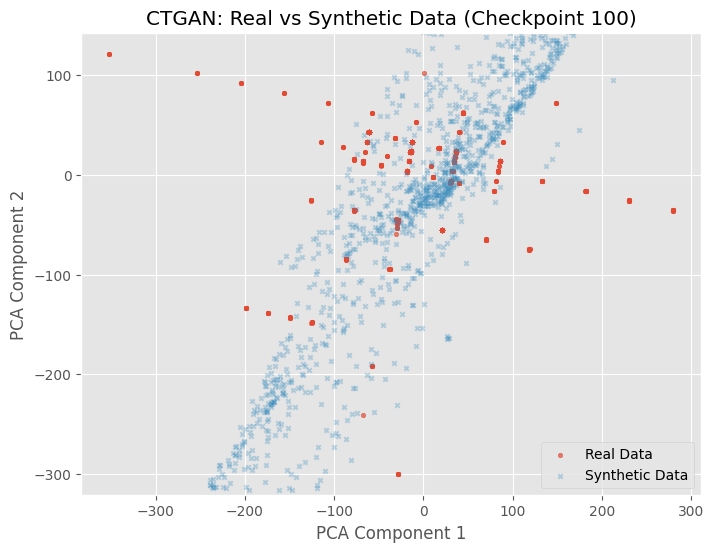

In [18]:
# Visualize CTGAN synthetic data evolution with PCA animation
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Directory containing generator checkpoints
checkpoint_dir = "ctgan"
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith("generator") and f.endswith(".pt")])

# Prepare real data PCA
pca = PCA(n_components=2)
real_pca = pca.fit_transform(X.values)

# Store PCA results for each checkpoint
synthetic_pca_list = []

# Generate synthetic data for each checkpoint
for checkpoint in checkpoints:
    generator.load_state_dict(torch.load(os.path.join(checkpoint_dir, checkpoint)))
    generator.eval()
    with torch.no_grad():
        z_noise = torch.randn(X.shape[0], noise_dim, device=device)
        synthetic_data = generator(z_noise, torch.tensor(y.values, dtype=torch.float32).to(device)).cpu().numpy()
        synthetic_pca = pca.transform(synthetic_data)
        synthetic_pca_list.append(synthetic_pca)

# Create a figure for the animation
fig, ax = plt.subplots(figsize=(8, 6))

# Initialize the scatter plots
real_scatter = ax.scatter(real_pca[:, 0], real_pca[:, 1], label='Real Data', alpha=0.7, s=10)
synthetic_scatter = ax.scatter([], [], label='Synthetic Data', alpha=0.3, s=10, marker='x')

# Set up the plot
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_title('CTGAN: Real vs Synthetic Data Over Time')
ax.legend()

# Update function for the animation
def update(frame):
    synthetic_scatter.set_offsets(synthetic_pca_list[frame])
    ax.set_title(f'CTGAN: Real vs Synthetic Data (Checkpoint {frame + 1})')

# Create the animation
ani = FuncAnimation(fig, update, frames=len(synthetic_pca_list), interval=500)

# Save the animation as a video or display it
ani.save('ctgan_pca_evolution.mp4', writer='ffmpeg', fps=2)
plt.show()

# Verification Network

50/50 threshold for Hardness (HV): 216.0


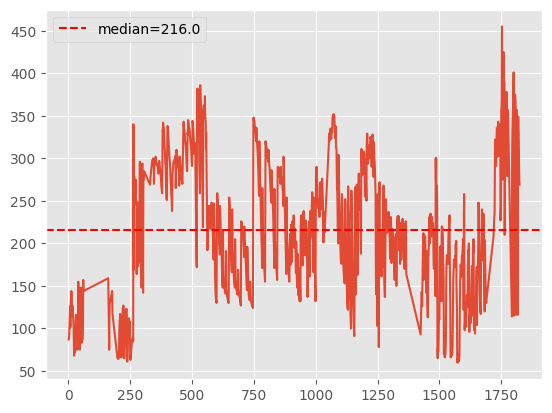

In [19]:
# Plot Hardness (HV) and compute the median threshold
plt.plot((y['Hardness (HV)']))

# Compute the median hardness as a 50/50 threshold
median_threshold = y['Hardness (HV)'].median()
print(f"50/50 threshold for Hardness (HV): {median_threshold}")

# Plot threshold line
plt.axhline(median_threshold, color='red', linestyle='--', label=f"median={median_threshold:.1f}")
plt.legend()
plt.show()

In [32]:
# Define and train the HardnessClassifier neural network
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim

class HardnessClassifier(nn.Module):
    def __init__(self, input_dim):
        super(HardnessClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

# Prepare the data for binary classification
y_binary = (y['Hardness (HV)'] > median_threshold).astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(X.values, y_binary.values, test_size=0.05, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hardness_classifier = HardnessClassifier(input_dim=X.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(hardness_classifier.parameters(), lr=1e-3)

# Training loop with early stopping
epochs = 300
patience = 20
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    hardness_classifier.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
        optimizer.zero_grad()
        preds = hardness_classifier(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Validation
    hardness_classifier.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            preds = hardness_classifier(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    
    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(hardness_classifier.state_dict(), 'best_model.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Load the best model
hardness_classifier.load_state_dict(torch.load('best_model.pt'))

# Evaluate on the test set
hardness_classifier.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = hardness_classifier(xb).cpu().numpy()
        y_true.extend(yb.cpu().numpy())
        y_pred.extend((preds > 0.5).astype(int))

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

Epoch 1/300, Train Loss: 1.4965, Val Loss: 0.6431
Epoch 2/300, Train Loss: 0.6659, Val Loss: 0.6268
Epoch 3/300, Train Loss: 0.6764, Val Loss: 0.6369
Epoch 4/300, Train Loss: 0.7810, Val Loss: 0.6110
Epoch 5/300, Train Loss: 0.6824, Val Loss: 0.6132
Epoch 6/300, Train Loss: 0.6359, Val Loss: 0.6153
Epoch 7/300, Train Loss: 0.6266, Val Loss: 0.5917
Epoch 8/300, Train Loss: 0.6195, Val Loss: 0.7149
Epoch 9/300, Train Loss: 0.6581, Val Loss: 0.6847
Epoch 10/300, Train Loss: 0.6503, Val Loss: 0.6959
Epoch 11/300, Train Loss: 0.6318, Val Loss: 0.5708
Epoch 12/300, Train Loss: 0.5999, Val Loss: 0.5697
Epoch 13/300, Train Loss: 0.5811, Val Loss: 0.5518
Epoch 14/300, Train Loss: 0.6304, Val Loss: 0.5671
Epoch 15/300, Train Loss: 0.5792, Val Loss: 0.5572
Epoch 16/300, Train Loss: 0.5687, Val Loss: 0.6198
Epoch 17/300, Train Loss: 0.5867, Val Loss: 0.5515
Epoch 18/300, Train Loss: 0.5539, Val Loss: 0.5673
Epoch 19/300, Train Loss: 0.5462, Val Loss: 0.5328
Epoch 20/300, Train Loss: 0.5562, Val Lo

Testing synthetic generation and classification for above/below median hardness

--- Hardness target = 60.0 (Expected label=0) ---
ALAE: 25/1000 predicted above threshold (+25) | Accuracy: 0.975
CVAE: 115/1000 predicted above threshold (+115) | Accuracy: 0.885
CTGAN: 705/1000 predicted above threshold (+705) | Accuracy: 0.295

--- Hardness target = 64.0 (Expected label=0) ---
ALAE: 23/1000 predicted above threshold (+23) | Accuracy: 0.977
CVAE: 102/1000 predicted above threshold (+102) | Accuracy: 0.898
CTGAN: 562/1000 predicted above threshold (+562) | Accuracy: 0.438

--- Hardness target = 68.0 (Expected label=0) ---
ALAE: 27/1000 predicted above threshold (+27) | Accuracy: 0.973
CVAE: 99/1000 predicted above threshold (+99) | Accuracy: 0.901
CTGAN: 477/1000 predicted above threshold (+477) | Accuracy: 0.523

--- Hardness target = 72.0 (Expected label=0) ---
ALAE: 22/1000 predicted above threshold (+22) | Accuracy: 0.978
CVAE: 101/1000 predicted above threshold (+101) | Accuracy: 0.8

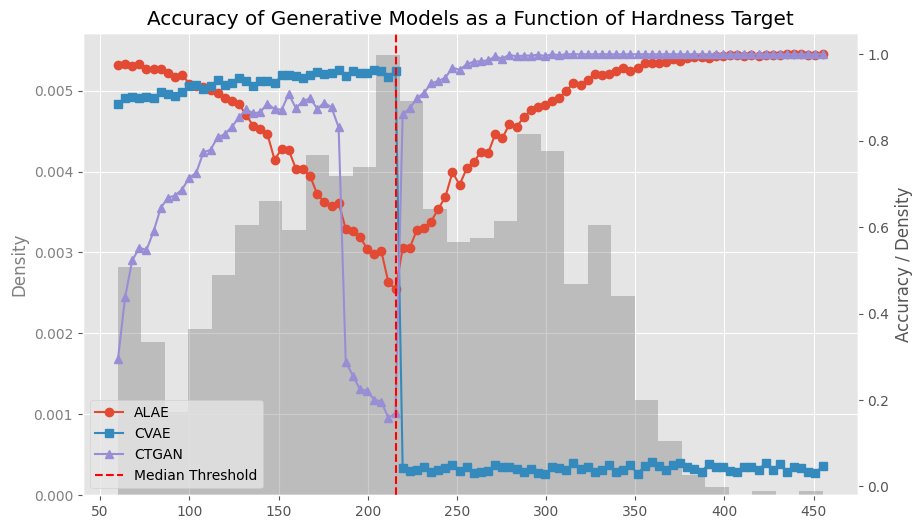

In [62]:
import matplotlib.pyplot as plt

hardness_targets = np.linspace(np.min(y['Hardness (HV)']), np.max(y['Hardness (HV)']), 100)
num_samples = 1000
conductivity_mean = np.mean(y['Electrical conductivity (%IACS)'])
conductivity_std = np.std(y['Electrical conductivity (%IACS)'])

# Initialize lists to store accuracies for each model
hardness_values = []
accuracy_alae = []
accuracy_cvae = []
accuracy_ctgan = []

print("Testing synthetic generation and classification for above/below median hardness")

for target in hardness_targets:
    # Determine the expected label (1 if above threshold, 0 if below)
    expected_label = 1 if target > median_threshold else 0
    expected_labels = np.full(num_samples, expected_label)

    # Generate conditional input: fixed hardness, random conductivity
    cond_np = np.column_stack([
        np.full(num_samples, target),
        np.random.normal(conductivity_mean, conductivity_std, num_samples)
    ])
    cond = torch.tensor(cond_np, dtype=torch.float32).to(device)

    # Sample latent vectors from standard normal for generative models
    z_prior = torch.randn(num_samples, latent_dim, device=device)

    print(f"\n--- Hardness target = {target:.1f} (Expected label={expected_label}) ---")

    # --- ALAE (Adversarial Latent Autoencoder) ---
    syn_X_alae = decoder_aae(z_prior, cond)
    hardness_classifier.eval()
    with torch.no_grad():
        alaepreds = (hardness_classifier(syn_X_alae) > 0.5).int().cpu().numpy().flatten()
    n_positive_alae = alaepreds.sum()
    acc_alae = accuracy_score(expected_labels, alaepreds)
    diff_alae = n_positive_alae - (num_samples if expected_label == 1 else 0)
    print(f"ALAE: {n_positive_alae}/{num_samples} predicted above threshold "
          f"({'+' if diff_alae > 0 else ''}{diff_alae}) | Accuracy: {acc_alae:.3f}")

    # --- CVAE (Conditional Variational Autoencoder) ---
    syn_X_cvae = model.dec(z_prior, cond)
    with torch.no_grad():
        cvaepreds = (hardness_classifier(syn_X_cvae) > 0.5).int().cpu().numpy().flatten()
    n_positive_cvae = cvaepreds.sum()
    acc_cvae = accuracy_score(expected_labels, cvaepreds)
    diff_cvae = n_positive_cvae - (num_samples if expected_label == 1 else 0)
    print(f"CVAE: {n_positive_cvae}/{num_samples} predicted above threshold "
          f"({'+' if diff_cvae > 0 else ''}{diff_cvae}) | Accuracy: {acc_cvae:.3f}")

    # --- CTGAN (Conditional Tabular GAN) ---
    z_ctgan = torch.randn(num_samples, noise_dim, device=device)
    syn_X_ctgan = generator(z_ctgan, cond)
    with torch.no_grad():
        ctganpreds = (hardness_classifier(syn_X_ctgan) > 0.5).int().cpu().numpy().flatten()
    n_positive_ctgan = ctganpreds.sum()
    acc_ctgan = accuracy_score(expected_labels, ctganpreds)
    diff_ctgan = n_positive_ctgan - (num_samples if expected_label == 1 else 0)
    print(f"CTGAN: {n_positive_ctgan}/{num_samples} predicted above threshold "
          f"({'+' if diff_ctgan > 0 else ''}{diff_ctgan}) | Accuracy: {acc_ctgan:.3f}")

    # Store results for visualization
    hardness_values.append(target)
    accuracy_alae.append(acc_alae)
    accuracy_cvae.append(acc_cvae)
    accuracy_ctgan.append(acc_ctgan)

# Visualization of accuracy as a function of hardness target
plt.figure(figsize=(10, 6))

ax1 = plt.gca()
ax2 = ax1.twinx()

# Add a secondary y-axis for the histogram
ax1.hist(y['Hardness (HV)'], bins=30, color='gray', density=True, alpha=0.4)
ax1.set_ylabel('Density', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# Plot accuracy curves
ax2.plot(hardness_values, accuracy_alae, label='ALAE', marker='o')
ax2.plot(hardness_values, accuracy_cvae, label='CVAE', marker='s')
ax2.plot(hardness_values, accuracy_ctgan, label='CTGAN', marker='^')

# Overlay histogram for hardness target distribution
#plt.hist(y['Hardness (HV)'], bins=30, alpha=0.3, color='gray', label='Hardness Distribution', density=True)

# Add median threshold line
plt.axvline(median_threshold, color='red', linestyle='--', label='Median Threshold')

# Labels, title, and legend
plt.xlabel('Hardness Target')
plt.ylabel('Accuracy / Density')
plt.title('Accuracy of Generative Models as a Function of Hardness Target')
plt.legend()
plt.grid()
plt.show()
